# Proyek Analisis Data: Brazilian E-Commerce Public Dataset by Olist
- **Nama:** Albar Pambagio Arioseto
- **Email:** albarpambagio@gmail.com
- **ID Dicoding:** albarpambagio 

## Menentukan Pertanyaan Bisnis

- bagaimana performa nilai penjualan dari sao paulo pada tahun 2018?
- bagaimana performa skor review produk dari sao paulo pada tahun 2018?

## Import Semua Packages/Library yang Digunakan

In [57]:
import pandas as pd
import altair as alt

## Data Wrangling

### Gathering Data

In [58]:
orders = pd.read_csv('data/olist_orders_dataset.csv')
customers = pd.read_csv('data/olist_customers_dataset.csv')
payments = pd.read_csv('data/olist_order_payments_dataset.csv')
reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')

In [59]:
# Filter for São Paulo customers only
sao_paulo_customers = customers[customers['customer_state'] == 'SP']['customer_id'].unique()

In [60]:
# Filter orders by São Paulo customers
sao_paulo_orders = orders[orders['customer_id'].isin(sao_paulo_customers)]

In [61]:
# Filter orders for 2018 only
sao_paulo_orders['order_purchase_timestamp'] = pd.to_datetime(sao_paulo_orders['order_purchase_timestamp'])
sao_paulo_orders_2018 = sao_paulo_orders[
    (sao_paulo_orders['order_purchase_timestamp'] >= '2018-01-01') & 
    (sao_paulo_orders['order_purchase_timestamp'] <= '2018-12-31')
]

C:\Users\USER\AppData\Local\Temp\ipykernel_5052\221366395.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sao_paulo_orders['order_purchase_timestamp'] = pd.to_datetime(sao_paulo_orders['order_purchase_timestamp'])


In [62]:
# Get order_ids for 2018 São Paulo orders
sp_order_ids_2018 = sao_paulo_orders_2018['order_id'].unique()

In [63]:
# Get payment information for these orders
sp_payments_2018 = payments[payments['order_id'].isin(sp_order_ids_2018)]

# Get review information for these orders
sp_reviews_2018 = reviews[reviews['order_id'].isin(sp_order_ids_2018)]

In [64]:
# Convert review date to datetime
sp_reviews_2018['review_creation_date'] = pd.to_datetime(sp_reviews_2018['review_creation_date'])

C:\Users\USER\AppData\Local\Temp\ipykernel_5052\273568301.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_reviews_2018['review_creation_date'] = pd.to_datetime(sp_reviews_2018['review_creation_date'])


In [65]:
# Extract month from timestamps
sao_paulo_orders_2018['month'] = sao_paulo_orders_2018['order_purchase_timestamp'].dt.month
sp_reviews_2018['month'] = sp_reviews_2018['review_creation_date'].dt.month

C:\Users\USER\AppData\Local\Temp\ipykernel_5052\3366326652.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sao_paulo_orders_2018['month'] = sao_paulo_orders_2018['order_purchase_timestamp'].dt.month
C:\Users\USER\AppData\Local\Temp\ipykernel_5052\3366326652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_reviews_2018['month'] = sp_reviews_2018['review_creation_date'].dt.month


**Insight:**
- dataset bersumber dari kaggle
- format dataset: csv

### Assessing Data

#### Checking missing value

In [66]:
sp_payments_2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24669 entries, 1 to 103881
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_id              24669 non-null  object 
 1   payment_sequential    24669 non-null  int64  
 2   payment_type          24669 non-null  object 
 3   payment_installments  24669 non-null  int64  
 4   payment_value         24669 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 1.1+ MB


In [67]:
sp_reviews_2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23829 entries, 0 to 99218
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                23829 non-null  object        
 1   order_id                 23829 non-null  object        
 2   review_score             23829 non-null  int64         
 3   review_comment_title     5040 non-null   object        
 4   review_comment_message   9237 non-null   object        
 5   review_creation_date     23829 non-null  datetime64[ns]
 6   review_answer_timestamp  23829 non-null  object        
 7   month                    23829 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(5)
memory usage: 1.5+ MB


#### Checking duplicates

In [68]:
sp_payments_2018.duplicated().sum()

np.int64(0)

In [69]:
sp_reviews_2018.duplicated().sum()

np.int64(0)

#### Checking outlier

In [70]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return outliers

In [71]:
outliers_p = detect_outliers_iqr(sp_payments_2018, 'payment_value')
outliers_p

,order_id,payment_sequential,payment_type,payment_installments,payment_value
26,d0a945f85ba1074b60aac97ade7e240e,1,credit_card,2,541.00
52,2e2c60b99754ae1e4d8b18846cfec9f2,1,credit_card,4,542.66
54,95442deb81a5d91c97c0df96b431634a,1,boleto,1,368.98
172,1594012ccc1b0770373ce691d697e5ae,1,credit_card,8,362.17
177,b545ba7b0bd67a3128185c7214704319,1,credit_card,8,340.08
...,...,...,...,...,...
103465,656689d74b6f04ec228f13e98fc9b15b,1,boleto,1,548.90
103484,0cf1684e713ddfe42529ec72206b25b3,1,credit_card,10,551.49
103498,b5b0b49d9903b852bf6c638643a89dc3,1,boleto,1,334.86
103813,2ab10ab526351fd3b05219e9eb4f7d9f,1,credit_card,8,366.73


In [72]:
outliers = detect_outliers_iqr(sp_reviews_2018, 'review_score')
outliers

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,month
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13,2018-04-16 00:39:37,4
19,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,2018-08-15,2018-08-15 04:10:37,8
89,65dfeb60c40e3cbb0a1838285d86f885,a2714ecbf6eeb3bb9cd7dba6dc1c5e82,1,NaN,Pedi reembolso e sem resposta até momento,2018-03-08,2018-03-08 12:27:34,3
91,1090909faae22e5ab76903e8493063f1,a1341cb83bbf1b47392f4a3685d56bad,1,NaN,NaN,2018-03-07,2018-03-07 15:32:23,3
149,ef8ae544c432bb1053ba5990bd0d6227,e18ebd6286697a3f0f6fe267d8286cb2,1,NaN,EU NÃO RECEBI O PRODUTO E CONSTA NO SISTEMA QU...,2018-01-12,2018-01-13 00:28:49,1
...,...,...,...,...,...,...,...,...
99081,dfb01be03c8f304bb01e3d2d90719a5b,c5d41b216e4b42500c5da2be17a74065,1,NaN,"Meus pedidos estão dando como entregues , mais...",2018-05-29,2018-05-31 13:35:06,5
99091,fade356e7332606aa22776d8d553cdce,837b75362f8a7c08c85182dfd16cb72d,1,NaN,Ainda nao recevi o produto.,2018-08-12,2018-08-12 13:51:31,8
99139,cadeddfc924c941517913adcc05dcb26,5f0729d8bd88589e8501140a9eb86ed3,2,NaN,"nao satifez minhas expectativas, não funciona ...",2018-02-03,2018-02-06 11:52:01,2
99200,2ee221b28e5b6fceffac59487ed39348,f2d12dd37eaef72ed7b1186b2edefbcd,2,Foto enganosa,Foto muito diferente principalmente a graninha...,2018-03-28,2018-05-25 01:23:26,3


##### Box Plot: Payment Value

In [84]:
# Merge orders with payments
orders_payments = pd.merge(orders, payments, on='order_id')

In [85]:
# Merge with reviews
orders_payments_reviews = pd.merge(orders_payments, reviews, on='order_id')

In [86]:
# Merge with customers (to get location info if needed)
merged_df = pd.merge(orders_payments_reviews, customers, on='customer_id')

# Convert order date to datetime
merged_df['order_purchase_timestamp'] = pd.to_datetime(merged_df['order_purchase_timestamp'])

# Optional: Filter São Paulo + 2018 only
merged_df = merged_df[
    (merged_df['customer_city'].str.lower() == 'sao paulo') &
    (merged_df['order_purchase_timestamp'].dt.year == 2018)
]

# Preview
merged_df.head()

,order_id,payment_value,review_score
16,5ff96c15d0b717ac6ad1f3d77225a350,32.70,5
17,432aaf21d85167c2c86ec9448c4e42cc,54.36,4
25,f848643eec1d69395095eb3840d2051e,88.90,5
26,2807d0e504d6d4894d41672727bc139f,17.28,3
43,7206b86ea789983f7a273ea7fa0bc2a8,49.69,3


In [103]:
# Box plot for payment_value
box_payment = alt.Chart(merged_df).mark_boxplot().encode(
    y=alt.Y('payment_value', title='Payment Value')
).properties(
    width=200,
    height=300,
    title='Box Plot of Payment Value'
)

box_payment

alt.Chart(...)

##### Box Plot: Review Score

In [104]:
# Box plot for review_score
box_review = alt.Chart(merged_df).mark_boxplot().encode(
    y=alt.Y('review_score:Q', title='Review Score')
).properties(
    width=200,
    height=300,
    title='Box Plot of Review Score'
)

box_review

alt.Chart(...)

**Insight:**
- tidak terdapat missing value
- tidak terdapat duplicate data
- ada sekitar 7% outliers di nilai pembayaran
- ada sekitar 12% outliers di skor review

### Cleaning Data

**Insight:**
- Outlier tidak ditangani secara khusus karena diperlukan investigasi lebih lanjut untuk memastikan apakah outlier tersebut merupakan kesalahan data atau justru mencerminkan kondisi sebenarnya.
- Selain itu, tidak dilakukan proses penghapusan (dropping) maupun imputasi data, karena hal tersebut tidak dibutuhkan untuk menjawab dua pertanyaan analisis yang telah disebutkan sebelumnya.

## Exploratory Data Analysis (EDA)

### Exploring Payment Value 

#### Descriptive stats: Payment Value

In [98]:
sp_payments_2018.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
5,298fcdf1f73eb413e4d26d01b25bc1cd,1,credit_card,2,96.12
18,8ac09207f415d55acff302df7d6a895c,1,credit_card,4,244.15
26,d0a945f85ba1074b60aac97ade7e240e,1,credit_card,2,541.00


In [99]:
sp_payments_2018['payment_value'].describe()

count    24669.000000
mean       138.614395
std        185.739511
min          0.000000
25%         51.130000
50%         90.990000
75%        158.790000
max       4513.320000
Name: payment_value, dtype: float64

#### Payment Value Distribution

In [95]:
# Histogram for payment_value
hist_payment = alt.Chart(merged_df).mark_bar().encode(
    alt.X('payment_value', bin=alt.Bin(maxbins=50), title='Payment Value'),
    alt.Y('count()', title='Count')
).properties(
    width=400,
    height=300,
    title='Histogram of Payment Value'
)

hist_payment

alt.Chart(...)

#### Averaged Monthly Payment Value

In [73]:
# Prepare monthly payment data
monthly_payments = sp_payments_2018.merge(
    sao_paulo_orders_2018[['order_id', 'month']], 
    on='order_id', 
    how='left'
)

In [111]:
# Calculate monthly payment statistics
monthly_payment_stats = monthly_payments.groupby('month').agg(
    total_payment=('payment_value', 'sum'),
    avg_payment=('payment_value', 'mean'),
    order_count=('order_id', 'nunique')
).reset_index()

In [75]:
monthly_payment_stats.head()

,month,total_payment,avg_payment,order_count
0,1,430306.48,135.273964,3052
1,2,358518.49,128.363226,2703
2,3,441724.26,140.229924,3037
3,4,452747.67,142.463081,3059
4,5,492978.52,148.936109,3207


In [76]:
monthly_payment_stats['avg_payment'].describe()

count     10.000000
mean     165.020124
std       82.879280
min      128.363226
25%      135.912673
50%      139.275169
75%      143.338270
max      400.363750
Name: avg_payment, dtype: float64

### Exploring Review Score

#### Descriptive Stats: Review Score

In [100]:
sp_reviews_2018.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,month
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59,1
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13,3
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13,2018-04-16 00:39:37,4
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22,2018-05-23 16:45:47,5
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16,2018-02-20 10:52:22,2


In [101]:
sp_reviews_2018['review_score'].describe()

count    23829.000000
mean         4.191573
std          1.273008
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score, dtype: float64

#### Review Score Distribution

In [102]:
# Histogram for review_score
hist_review = alt.Chart(merged_df).mark_bar().encode(
    alt.X('review_score:O', title='Review Score'),  # Treat as ordinal
    alt.Y('count()', title='Count')
).properties(
    width=400,
    height=300,
    title='Histogram of Review Score'
)

hist_review

alt.Chart(...)

#### Averaged Monthly Review Score

In [108]:
#Calculate monthly review statistics
monthly_review_stats = sp_reviews_2018.groupby('month').agg(
    avg_score=('review_score', 'mean'),
    review_count=('review_id', 'count')
).reset_index()

In [109]:
monthly_review_stats.head()

,month,avg_score,review_count
0,1,4.284615,1950
1,2,4.083969,2620
2,3,3.979211,3271
3,4,4.195694,3112
4,5,4.281655,3238


In [113]:
monthly_review_stats['avg_score'].describe()

count    8.000000
mean     4.198373
std      0.115121
min      3.979211
25%      4.163892
50%      4.224971
75%      4.282395
max      4.317053
Name: avg_score, dtype: float64

### Correlation Analysis Between Payment Value and Review Score

In [87]:
# Keep only relevant columns for correlation
df_corr = merged_df[['order_id', 'payment_value', 'review_score']].dropna()

In [88]:
# Calculate correlation coefficient
correlation = df_corr['payment_value'].corr(df_corr['review_score'])
print(f"Correlation between payment value and review score: {correlation:.3f}")

Correlation between payment value and review score: -0.056


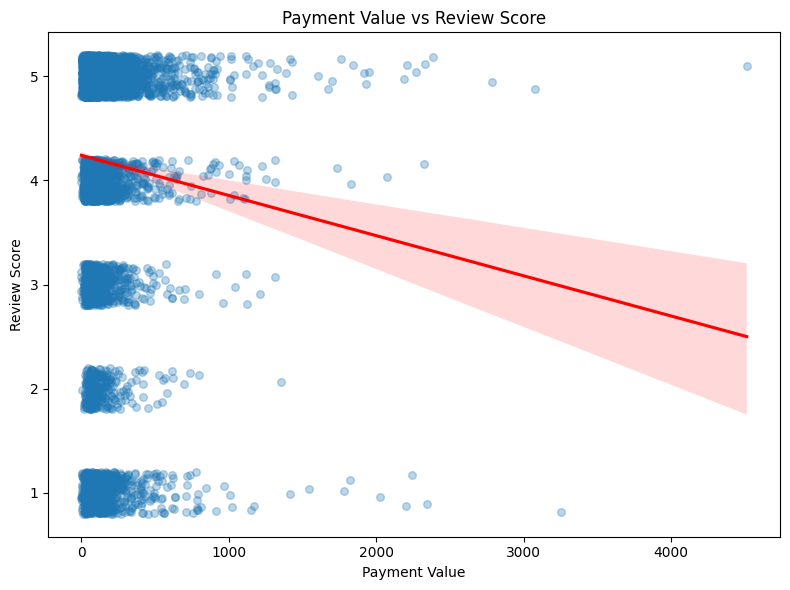

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(
    x='payment_value',
    y='review_score',
    data=df_corr,
    scatter_kws={'alpha': 0.3, 's': 30},
    x_jitter=0,
    y_jitter=0.2,  # Add vertical jitter to spread overlapping points
    line_kws={'color': 'red'}
)

plt.title('Payment Value vs Review Score')
plt.xlabel('Payment Value')
plt.ylabel('Review Score')
plt.tight_layout()
plt.show()

## Insights
- data hanya tersedia dari bulan januari sampai oktober untuk data nilai pembayaran
- data hanya tersedia dari bulan januari sampai agustus untuk data review
- range data payment value: 0 sampai 4513
- range data review score: 1-5
- rerata nilai pembayaran pada tahun 2018 untuk sao paulo adalah 165 brazilian real (paling rendahnya 128 dan paling tingginya 400) (setelah dikelompokkan per bulan), reratanya sebelum dikelompokkan adalah 138 (dengan standar deviation 185)
- rerata skor pada tahun 2018 untuk sao paulo adalah 4.19 (dengan standar deviasi 1.27 untuk ungrouped data dan 0.11 untuk grouped data)
- distribusi data payment value cenderung terkumpul di sebelah kiri (right skewed) dan untuk distribusi review score cenderung terkumpul di nilai 5 (left skewed)
- korelasi antara payment value dan review score adalah -0.05 (negatively correlated), artinya setiap kenaikan 1 unit di payment value akan diiringi penurunan nilai review score sebesar 0.05

## Visualization

### Pertanyaan 1:

In [80]:
# Create Altair visualization for average payment by month
avg_payment_chart = alt.Chart(monthly_payment_stats).mark_bar().encode(
    x=alt.X('month:N', title='Month'),
    y=alt.Y('avg_payment:Q', title='Average Payment Value (R$)'),
    tooltip=['month', 'avg_payment']
).properties(
    title='Average Payment Value by Month - São Paulo (2018)',
    width=600,
    height=400
)

# Add text labels for the average payment values
payment_text = avg_payment_chart.mark_text(
    align='center',
    baseline='top',
    dy=10
).encode(
    text=alt.Text('avg_payment:Q', format=',.2f')
)

In [81]:
# Display the charts with text labels
payment_chart_with_text = avg_payment_chart + payment_text

# Show the charts
payment_chart_with_text.display()

alt.LayerChart(...)

### Pertanyaan 2:

In [82]:
# Create Altair visualization for average review score by month
avg_review_chart = alt.Chart(monthly_review_stats).mark_bar(color='orange').encode(
    x=alt.X('month:N', title='Month'),
    y=alt.Y('avg_score:Q', title='Average Review Score (1-5)', scale=alt.Scale(domain=[0, 5])),
    tooltip=['month', 'avg_score']
).properties(
    title='Average Review Score by Month - São Paulo (2018)',
    width=600,
    height=400
)

# Add text labels for the average review scores
review_text = avg_review_chart.mark_text(
    align='center',
    baseline='top',
    dy=10
).encode(
    text=alt.Text('avg_score:Q', format='.2f')
)

In [83]:
review_chart_with_text = avg_review_chart + review_text
review_chart_with_text.display()

alt.LayerChart(...)

## Conclusion

### Temuan
- ada lonjakan rerata nilai pembelian pada bulan november 2018 sebesar 400 brazilian real, sedangkan bulan selainnya tidak ada pergerakan yang drastis (cenderung stabil)
- ada penurunan rerata review pada bulan maret 2018 menjadi 3.98, sedangkan di bulan lainnya skor review cukup bagus dan tidak ada pergerakan yang drastis (cenderung stabil)

### Rekomendasi
- perlu diadakan investigasi apakah lonjakan tersebut berasosiasi dengan strategi marketing tertentu atau tidak, sehingga inisiatifnya bisa direplikasi di bulan lain
- perlu adanya analisis lanjutan terkait penurunan review di bulan maret, yang selanjutnya bisa diketahui apa akar masalah yang menjadi penyebab penurunan tersebut sehingga dapat diselesaikan dan dicegah di kemudian hari